In [32]:
# Author: James Meehan
# Date: 8/15/18
# Description: Machine Learning Model to predict fantasy wide receiver scores on a weekly basis
# Cepheus Capstone Project

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

In [33]:
# pull in data and separate between data stack, labels, and actual scores
df = pd.read_csv('WRRev2.csv', sep=',', )
pts_targets = df
labels = df

labels = labels.loc[0:, 'fname':'actual']
labels = labels.values

df = df.loc[0:, 'rating':'retd_2wk']
pts_targets = pts_targets.loc[0:, 'actual']

df = df.values
df.shape

(3098, 25)

In [34]:
# normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# split into training and test samples (80% training / 20% test)
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_targets[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_targets[train_samples:]

[[-9.49537226e-02  1.02682845e+00  6.39730502e-16 ... -1.27650508e+00
  -1.39572405e+00 -5.80752395e-01]
 [-9.49537226e-02  1.02682845e+00  6.39730502e-16 ... -6.15702913e-02
   1.43270830e+00  2.89590639e+00]
 [ 1.78689657e-01 -9.73872514e-01  1.76649839e+00 ...  3.43407973e-01
   4.29900470e-01 -5.80752395e-01]
 ...
 [-1.46317062e+00 -9.73872514e-01  6.39730502e-16 ... -6.15702913e-02
  -3.67203193e-01 -5.80752395e-01]
 [ 3.15511346e-01  1.02682845e+00 -7.54455406e-01 ... -8.71526820e-01
  -1.19001988e+00 -5.80752395e-01]
 [ 2.09419331e+00  1.02682845e+00  7.53615167e-01 ... -4.66548556e-01
  -5.98620385e-01 -5.80752395e-01]]


In [35]:
print("Training set: {}".format(train_inputs.shape))  # 2478 examples, 25 features
print("Testing set:  {}".format(test_inputs.shape))   # 620 examples, 25 features

Training set: (2478, 25)
Testing set:  (620, 25)


In [37]:
# build the neural network. Testing and refining the model found that 2 hidden layers with 50 neurons per layer
# produced the best results
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(50, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
   keras.layers.Dense(50, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])
  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 3,901
Trainable params: 3,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


..................................................

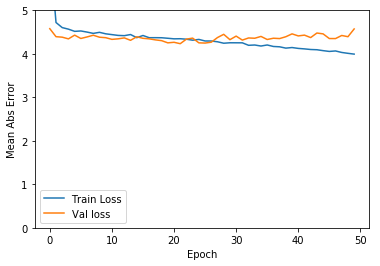

In [39]:
# graph training
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

In [40]:
# calculate performance
[loss, mae] = model.evaluate(test_inputs, test_targets, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    4.55
Testing set Mean Squared Error:   32.44


In [10]:
# get predictions
test_predictions = model.predict(test_inputs).flatten()

print(test_predictions)

[ 7.371643   7.204803  10.427268   8.317943   8.317943   8.317943
 11.272898  11.272898  11.272898  11.272898   8.317943   6.698992
  6.284078   6.271683   7.18606    8.157736   9.207905   6.013356
  7.2637644  6.7486467 10.7905655  9.071781   9.948929   8.154152
  6.7772326  7.8219585 15.664368   8.842409   8.083654  13.599245
  5.3449907 14.811171   8.212087   7.616492   6.587398   4.947592
  7.4323187  9.871867  11.267133   7.6978445  7.1659555  5.8136263
  5.024408  11.134243  10.142519  12.627473  11.218672  12.179555
  9.350214   8.832903   5.3679643  8.67474    5.723031   7.609744
  7.9376793  8.301641  13.202685   7.6080356  7.574156   9.424428
  9.5975685  9.5975685  9.5975685  9.5975685  5.7171774  6.6508875
  6.9455657  6.1212955  9.660984   8.299788   7.839225   6.923867
  8.311722  11.516535   8.439455   6.745619   5.4099836  5.9464054
  7.8112555  8.350309   3.9802086  7.2100935  7.245872   5.1138973
  6.54666   11.803419  10.361477   8.83857    6.202423   7.3915772
  9.9

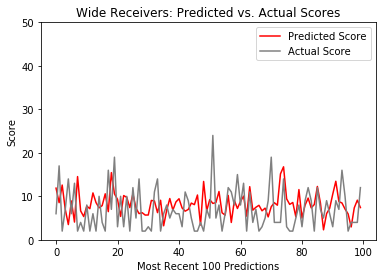

In [12]:
# graph predicted vs. actual scores
def plot_predict():
  plt.figure()
  plt.title('Wide Receivers: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[420:520]), label = "Predicted Score", color="red")
  plt.plot(np.array(test_targets[420:520]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [13]:
WRtest_labels = labels[train_samples:]

In [14]:
print(test_predictions)

[ 5.9904065   5.5149837   6.057619    6.5387044   6.5387044   6.5387044
  7.9091544   7.9091544   7.9091544   7.9091544   6.5387044   8.886618
  8.937111    5.233086   11.901816    8.585233   11.273398    4.604541
  5.2453256   5.1038356  10.11857     8.810531   10.046337    8.16452
  5.816319    5.26124    20.122011    6.3493667   6.8779354  12.93896
  4.790523   10.061203    6.7728353   7.3912606   5.9025693   3.2716064
  6.2717667   8.175551    9.2389145   6.3455014   6.969112    5.273337
  4.9770694   8.668542    7.2237263  16.44241     8.813582    9.326558
  9.046155    7.5146513   6.9195495   8.02136     6.2869453   7.7020316
  7.862796    7.405969   11.434707    8.809412    6.2714005   8.716363
  9.164247    9.164247    9.1642475   9.1642475   6.321006    7.0503993
  5.123998    6.374019    8.509461   11.903344    7.5600863   5.8838706
  4.6837826  10.661658    8.636333    5.9748015   6.91137     5.4673996
  8.10214     5.8280015   6.616354    7.416221    4.0379496   3.7234397
 

In [15]:
fullList = []

for i in range(len(test_predictions)):
    mylist = []
    mylist.append(WRtest_labels[i][0])
    mylist.append(WRtest_labels[i][1])
    mylist.append(WRtest_labels[i][2])
    mylist.append(WRtest_labels[i][3])
    mylist.append(WRtest_labels[i][4])
    mylist.append(test_predictions[i])
    fullList.append(mylist)
print (fullList)

[[' JuJu', ' Smith-Schuster', 5, 2017, 5, 5.9904065], [' Kamar', ' Aiken', 5, 2017, 2, 5.5149837], [' Keenan', ' Allen', 5, 2017, 6, 6.057619], [' Kelvin', ' Benjamin', 5, 2017, 11, 6.5387044], [' Kelvin', ' Benjamin', 5, 2017, 11, 6.5387044], [' Kelvin', ' Benjamin', 5, 2017, 11, 6.5387044], [' Kelvin', ' Benjamin', 5, 2017, 11, 7.9091544], [' Kelvin', ' Benjamin', 5, 2017, 11, 7.9091544], [' Kelvin', ' Benjamin', 5, 2017, 11, 7.9091544], [' Kelvin', ' Benjamin', 5, 2017, 11, 7.9091544], [' Kelvin', ' Benjamin', 5, 2017, 11, 6.5387044], [' Larry', ' Fitzgerald', 5, 2017, 5, 8.886618], [' Marqise', ' Lee', 5, 2017, 4, 8.937111], [' Marquise', ' Goodwin', 5, 2017, 11, 5.233086], [' Martavis', ' Bryant', 5, 2017, 3, 11.901816], [' Marvin', ' Jones', 5, 2017, 5, 8.585233], [' Mike', ' Evans', 5, 2017, 4, 11.273398], [' Mike', ' Wallace', 5, 2017, 13, 4.604541], [' Nelson', ' Agholor', 5, 2017, 15, 5.2453256], [' Paul', ' Richardson', 5, 2017, 3, 5.1038356], [' Pierre', ' Garcon', 5, 2017,

In [16]:
import csv
from pandas import read_csv 

with open("WRtestOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in fullList:
        cw.writerow(i)
        
WRformat = read_csv('WRtestOutput.csv', sep=',')
WRformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
        
WRformat.to_csv('WRtestOutput.csv', index=False)

In [17]:
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [18]:
#Create cursor with which to execute queries
cur = conn.cursor()

In [19]:
#parse csv
with open ('WRtestOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kamar', ' Aiken', '5', '2017', '2', '5.5149837')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Keenan', ' Allen', '5', '2017', '6', '6.057619')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '5', '2017', '11', '6.5387044')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '5', '2017', '11', '6.5387044')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '5', '2017', '11', '6.5387044')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '5', '2017', '11', '7.909154400000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '5', '2017', '11', '7.909154400000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin',

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Campanaro', '6', '2017', '2', '5.8838706')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Wallace', '6', '2017', '3', '4.6837826')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Evans', '6', '2017', '15', '10.661658000000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Nelson', ' Agholor', '6', '2017', '11', '8.636333')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Pierre', ' Garcon', '6', '2017', '5', '5.9748015')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Randall', ' Cobb', '6', '2017', '2', '6.91137')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Ricardo', ' Louis', '6', '2017', '2', '5.4673996')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Rishard', ' Matthews', '6',

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Crabtree', '9', '2017', '4', '6.506407')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Thomas', '9', '2017', '6', '9.922839')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mohamed', ' Sanu', '9', '2017', '8', '12.741123')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Nelson', ' Agholor', '9', '2017', '3', '6.136293')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Paul', ' Richardson', '9', '2017', '4', '8.204001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Robby', ' Anderson', '9', '2017', '10', '5.827848')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Ryan', ' Grant', '9', '2017', '3', '5.4185767')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Taylor', ' Gabriel', '9', '2017', '

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Thomas', '11', '2017', '9', '9.841187')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mohamed', ' Sanu', '11', '2017', '9', '10.488896')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Paul', ' Richardson', '11', '2017', '5', '6.144164599999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Randall', ' Cobb', '11', '2017', '3', '8.375487')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Rishard', ' Matthews', '11', '2017', '17', '10.079917')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Robert', ' Woods', '11', '2017', '8', '12.391091000000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Roger', ' Lewis', '11', '2017', '5', '5.7724624')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Ryan', ' Gr

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Godwin', '14', '2017', '6', '6.1019816')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Moore', '14', '2017', '10', '4.343442400000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cody', ' Latimer', '14', '2017', '3', '7.272298299999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cole', ' Beasley', '14', '2017', '5', '5.8815')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cooper', ' Kupp', '14', '2017', '17', '8.09468')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Corey', ' Davis', '14', '2017', '2', '6.1100874')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Danny', ' Amendola', '14', '2017', '7', '4.881776')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Davante', ' Adams', '14'

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Golden', ' Tate', '15', '2017', '3', '11.529760000000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jamison', ' Crowder', '15', '2017', '11', '7.360705')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jarvis', ' Landry', '15', '2017', '9', '3.5434517999999997')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' JD', ' McKissic', '15', '2017', '5', '5.7862024000000005')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jeremy', ' Maclin', '15', '2017', '2', '9.474321')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jermaine', ' Kearse', '15', '2017', '2', '8.568315')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' JJ', ' Nelson', '15', '2017', '4', '5.1653485')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jordy',

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '17', '2017', '2', '8.755257')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '17', '2017', '2', '8.755257')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '17', '2017', '2', '8.443764999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '17', '2017', '2', '8.443764999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '17', '2017', '2', '8.755257')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '17', '2017', '2', '8.755257')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kendall', ' Wright', '17', '2017', '2', '4.959619')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kend

In [20]:
# import training data
training_predictions = model.predict(train_inputs).flatten()
print(labels[2478])
#training_predictions.shape

[' JuJu' ' Smith-Schuster' 5 2017 5]


In [21]:
trainList = []

for i in range(778, 2478):
    mylist = []
    mylist.append(labels[i][0])
    mylist.append(labels[i][1])
    mylist.append(labels[i][2])
    mylist.append(labels[i][3])
    mylist.append(labels[i][4])
    mylist.append(training_predictions[i])
    trainList.append(mylist)
print (trainList)

[[' AJ', ' Green', 3, 2015, 34, 14.256599], [' Allen', ' Robinson', 3, 2015, 6, 7.720758], [' Allen', ' Hurns', 3, 2015, 13, 7.846749], [' Amari', ' Cooper', 3, 2015, 12, 6.3209805], [' Antonio', ' Brown', 3, 2015, 10, 8.349712], [' Brandin', ' Cooks', 3, 2015, 7, 7.072307], [' Brandon', ' Marshall', 3, 2015, 15, 11.943358], [' Calvin', ' Johnson', 3, 2015, 7, 5.899018], [' Cecil', ' Shorts', 3, 2015, 5, 7.54351], [' Cole', ' Beasley', 3, 2015, 4, 5.449881], [' Danny', ' Amendola', 3, 2015, 9, 6.2463994], [' DeAndre', ' Hopkins', 3, 2015, 16, 10.143622], [' Demaryius', ' Thomas', 3, 2015, 14, 9.059533], [' Donte', ' Moncrief', 3, 2015, 9, 7.6019664], [' Doug', ' Baldwin', 3, 2015, 3, 5.6361294], [' Emmanuel', ' Sanders', 3, 2015, 8, 7.3270073], [' Golden', ' Tate', 3, 2015, 5, 7.5857124], [' Harry', ' Douglas', 3, 2015, 2, 4.8421664], [' James', ' Jones', 3, 2015, 19, 10.806388], [' Jamison', ' Crowder', 3, 2015, 6, 4.822989], [' Jarius', ' Wright', 3, 2015, 2, 3.3551612], [' Jarvis', 

In [22]:
import csv
from pandas import read_csv 

with open("WRtrainOutput.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in trainList:
        cw.writerow(i)
        
WRformat = read_csv('WRtrainOutput.csv', sep=',')
WRformat.columns = ['fname', 'lname', 'week', 'yr', 'actual', 'predicted']
        
WRformat.to_csv('WRtrainOutput.csv', index=False)

In [23]:
# put training predict data into database
#Create cursor with which to execute queries
cur = conn.cursor()

#parse csv
with open ('WRtrainOutput.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Allen', ' Robinson', '3', '2015', '6', '7.720758')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Allen', ' Hurns', '3', '2015', '13', '7.846749000000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Amari', ' Cooper', '3', '2015', '12', '6.3209805')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Antonio', ' Brown', '3', '2015', '10', '8.349712')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandin', ' Cooks', '3', '2015', '7', '7.072307')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' Marshall', '3', '2015', '15', '11.943358')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Calvin', ' Johnson', '3', '2015', '7', '5.899018')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cecil', ' Shorts', '3', '

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Bennie', ' Fowler', '5', '2015', '4', '5.998551')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandin', ' Cooks', '5', '2015', '16', '6.563115')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Bryan', ' Walters', '5', '2015', '6', '5.945911')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Calvin', ' Johnson', '5', '2015', '6', '8.687846')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Hogan', '5', '2015', '11', '8.356178')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cole', ' Beasley', '5', '2015', '4', '5.5350423')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Darrius', ' Heyward-Bey', '5', '2015', '2', '4.828903700000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' DeAndre', ' Hopkins', '5',

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Keenan', ' Allen', '6', '2015', '15', '7.6388693')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Lance', ' Moore', '6', '2015', '16', '7.840101')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Larry', ' Fitzgerald', '6', '2015', '9', '8.200617999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Leonard', ' Hankerson', '6', '2015', '3', '8.168196')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Malcom', ' Floyd', '6', '2015', '9', '7.5464406')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marquess', ' Wilson', '6', '2015', '5', '4.9791946')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marvin', ' Jones', '6', '2015', '15', '9.900549')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Floyd', '6'

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brian', ' Quick', '10', '2015', '3', '4.2305408')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Danny', ' Amendola', '10', '2015', '7', '5.685897')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Davante', ' Adams', '10', '2015', '7', '10.338549')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Demaryius', ' Thomas', '10', '2015', '7', '12.773495')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Devin', ' Funchess', '10', '2015', '4', '5.3630404')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Dez', ' Bryant', '10', '2015', '4', '9.867664')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Dwayne', ' Harris', '10', '2015', '14', '9.782923')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Eric', ' Decker', '10', '2015'

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Calvin', ' Johnson', '12', '2015', '27', '12.371862')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cecil', ' Shorts', '12', '2015', '9', '7.314436')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Givens', '12', '2015', '4', '4.926951')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cole', ' Beasley', '12', '2015', '10', '5.489054')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' DeAndre', ' Hopkins', '12', '2015', '3', '2.6144638')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Demaryius', ' Thomas', '12', '2015', '3', '11.1483965')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Denard', ' Robinson', '12', '2015', '2', '-0.96639454')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' DeSean', ' Jackson', 

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Martavis', ' Bryant', '14', '2015', '4', '5.7805133')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marvin', ' Jones', '14', '2015', '6', '3.7406723')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Floyd', '14', '2015', '16', '9.796613')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Evans', '14', '2015', '3', '9.392934')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mohamed', ' Sanu', '14', '2015', '2', '4.122726')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Nate', ' Washington', '14', '2015', '4', '7.951884700000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Nick', ' Williams', '14', '2015', '4', '4.4563174000000005')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Odell', ' Beck

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Markus', ' Wheaton', '15', '2015', '12', '6.969786999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marlon', ' Moore', '15', '2015', '2', '4.836812999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marqise', ' Lee', '15', '2015', '4', '5.29334')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marques', ' Colston', '15', '2015', '9', '7.070825999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Martavis', ' Bryant', '15', '2015', '8', '7.1898')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marvin', ' Jones', '15', '2015', '8', '11.198193')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Crabtree', '15', '2015', '7', '7.1064296')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mich

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Wallace', '17', '2015', '2', '6.4347900000000005')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Evans', '17', '2015', '9', '10.158989')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Phillip', ' Dorsett', '17', '2015', '3', '5.0562434000000005')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Philly', ' Brown', '17', '2015', '5', '6.590012')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Pierre', ' Garcon', '17', '2015', '10', '6.483417')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Quinton', ' Patton', '17', '2015', '3', '6.582839999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Randall', ' Cobb', '17', '2015', '3', '4.7784486')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Rueben

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Phillip', ' Dorsett', '3', '2016', '2', '5.517483')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Philly', ' Brown', '3', '2016', '5', '5.038233999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Pierre', ' Garcon', '3', '2016', '5', '7.2483830000000005')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Quincy', ' Enunwa', '3', '2016', '3', '4.959128')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Randall', ' Cobb', '3', '2016', '3', '8.645833')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Rishard', ' Matthews', '3', '2016', '3', '4.677604')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Robert', ' Woods', '3', '2016', '5', '6.8976007')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Sammie', ' Coates', 

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Amari', ' Cooper', '6', '2016', '12', '8.152535')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Andrew', ' Hawkins', '6', '2016', '4', '5.5937285')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Anquan', ' Boldin', '6', '2016', '12', '9.000098')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Antonio', ' Brown', '6', '2016', '3', '4.5627455999999995')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' LaFell', '6', '2016', '7', '6.5489845')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' Marshall', '6', '2016', '7', '8.75962')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Breshad', ' Perriman', '6', '2016', '4', '6.073885400000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brian', ' Qui

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' DeSean', ' Jackson', '7', '2016', '3', '7.134024')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' DeVante', ' Parker', '7', '2016', '2', '5.2200446')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Dontrelle', ' Inman', '7', '2016', '5', '4.041686')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Dorial', ' Green-Beckham', '7', '2016', '6', '7.140730400000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Emmanuel', ' Sanders', '7', '2016', '8', '12.075583')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Golden', ' Tate', '7', '2016', '9', '4.96215')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jamison', ' Crowder', '7', '2016', '10', '8.073815')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jarvis', ' Landry

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jordan', ' Taylor', '10', '2016', '9', '6.27064')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Jordy', ' Nelson', '10', '2016', '18', '13.144333')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Julio', ' Jones', '10', '2016', '13', '8.364816000000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kelvin', ' Benjamin', '10', '2016', '7', '6.2834163')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Kendall', ' Wright', '10', '2016', '6', '4.1401386')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Marqise', ' Lee', '10', '2016', '5', '8.630563')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Thomas', '10', '2016', '2', '8.432757')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Evans', '10', 

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Allen', ' Robinson', '12', '2016', '2', '11.089819')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Allen', ' Hurns', '12', '2016', '7', '6.673546000000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Antonio', ' Brown', '12', '2016', '27', '16.79221')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' LaFell', '12', '2016', '3', '6.029804')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' Coleman', '12', '2016', '6', '4.563562999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Conley', '12', '2016', '2', '3.8129692000000004')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cole', ' Beasley', '12', '2016', '5', '4.2523045999999995')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUE

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Michael', ' Crabtree', '14', '2016', '2', '6.3717628')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Evans', '14', '2016', '4', '18.719279999999998')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Mike', ' Wallace', '14', '2016', '5', '4.8342279999999995')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Odell', ' Beckham', '14', '2016', '15', '10.690766')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Pierre', ' Garcon', '14', '2016', '11', '4.691631299999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Quincy', ' Enunwa', '14', '2016', '2', '5.871152400000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Randall', ' Cobb', '14', '2016', '3', '13.646287')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALU

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Quincy', ' Enunwa', '15', '2016', '6', '6.180704599999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Robby', ' Anderson', '15', '2016', '14', '7.1302304')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Seth', ' Roberts', '15', '2016', '2', '3.9754047')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Sterling', ' Shepard', '15', '2016', '11', '8.237618')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Steve', ' Smith', '15', '2016', '10', '8.084629')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Taylor', ' Gabriel', '15', '2016', '12', '7.327408999999999')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Ted', ' Ginn', '15', '2016', '12', '5.0909314000000006')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Ter

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Tyler', ' Boyd', '17', '2016', '4', '6.2735353')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Tyreek', ' Hill', '17', '2016', '5', '11.293113')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Tyrell', ' Williams', '17', '2016', '7', '6.602877')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Will', ' Fuller', '17', '2016', '2', '7.360113')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Willie', ' Snead', '17', '2016', '8', '9.672798')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Adam', ' Thielen', '3', '2017', '9', '5.5248422999999995')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' AJ', ' Green', '3', '2017', '17', '9.350342')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Albert', ' Wilson', '3', '2017', '7'

INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Antonio', ' Brown', '4', '2017', '3', '6.047060500000001')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Bennie', ' Fowler', '4', '2017', '3', '7.179231')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandin', ' Cooks', '4', '2017', '3', '11.064128')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brandon', ' Coleman', '4', '2017', '3', '6.0744443')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Brice', ' Butler', '4', '2017', '7', '6.446656')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Chris', ' Hogan', '4', '2017', '12', '11.149383')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cooper', ' Kupp', '4', '2017', '12', '5.9067115999999995')
INSERT INTO wr_results(fname, lname, week, yr, actual, predicted) VALUES (' Cordarrelle', ' Patte